In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle

import google.colab
google.colab.drive.mount("/content/drive")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATADIR = '/content/drive/MyDrive/seq_data/data_bookorder/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
class CTLSTMDataset(Dataset):
    ''' Dataset class for neural hawkes data
    '''
    def __init__(self, file_path):
        self.seq_type = []
        self.seq_time = []

        with open(file_path, 'rb') as f:

            if 'dev' in file_path:
                seqs = pickle.load(f, encoding='latin1')['dev']
            elif 'train' in file_path:
                seqs = pickle.load(f, encoding='latin1')['train']
            elif 'test' in file_path:
                seqs = pickle.load(f, encoding='latin1')['test']

            for idx, seq in enumerate(seqs):
                self.seq_type.append(torch.LongTensor([int(event['type_event']) for event in seq]))
                self.seq_time.append(torch.FloatTensor([float(event['time_since_last_event']) for event in seq]))

    def __len__(self):
        return len(self.seq_type)
    
    def __getitem__(self, index):

        sample = {'seq_type': self.seq_type[index], 'seq_time': self.seq_time[index]}

        return sample


In [131]:
dataset = CTLSTMDataset('/content/drive/MyDrive/Копия train.pkl')
#old_loader = DataLoader(dataset, batch_size=12,collate_fn=pad_batch_fn, shuffle=False)
new_loader = DataLoader(dataset, batch_size=12, shuffle=False)
for x in old_loader:
  old = x
for x in new_loader:
  new = x

In [132]:
def pad_batch_fn(batch_data):

    sorted_batch = sorted(batch_data, key=lambda x: x['seq_type'].size(), reverse=True)
    event_seqs = [seq['seq_type'].long() for seq in sorted_batch]
    time_seqs = [seq['seq_time'].float() for seq in sorted_batch]
    seqs_length = torch.LongTensor(list(map(len, event_seqs)))
    last_time_seqs = torch.stack([torch.sum(time_seq) for time_seq in time_seqs])
    print(seqs_length)

    event_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).long()
    time_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).float()

    for idx, (event_seq, time_seq, seqlen) in enumerate(zip(event_seqs, time_seqs, seqs_length)):
        event_seqs_tensor[idx, :seqlen] = torch.LongTensor(event_seq)
        time_seqs_tensor[idx, :seqlen] = torch.FloatTensor(time_seq)
    
    return event_seqs_tensor, time_seqs_tensor, last_time_seqs, seqs_length


In [134]:
def pad_bos(batch_data, type_size):
    event_seqs, time_seqs, total_time_seqs, seqs_length = batch_data
    pad_event_seqs = torch.zeros((event_seqs.size()[0], event_seqs.size()[1]+1)).long() * type_size
    pad_time_seqs = torch.zeros((time_seqs.size()[0], event_seqs.size()[1]+1)).float()

    pad_event_seqs[:, 1:] = event_seqs.clone()
    pad_event_seqs[:, 0] = type_size
    pad_time_seqs[:, 1:] = time_seqs.clone()

    return pad_event_seqs, pad_time_seqs, total_time_seqs, seqs_length


In [135]:
def pad_batch_fn(batch_data):
    sorted_batch = sorted(batch_data, key=lambda x: x['seq_type'].size(), reverse=True)
    event_seqs = [seq['seq_type'].long() for seq in sorted_batch]
    time_seqs = [seq['seq_time'].float() for seq in sorted_batch]
    seqs_length = torch.LongTensor(list(map(len, event_seqs)))
    last_time_seqs = torch.stack([torch.sum(time_seq) for time_seq in time_seqs])

    event_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).long()
    time_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).float()

    for idx, (event_seq, time_seq, seqlen) in enumerate(zip(event_seqs, time_seqs, seqs_length)):
        event_seqs_tensor[idx, :seqlen] = torch.LongTensor(event_seq)
        time_seqs_tensor[idx, :seqlen] = torch.FloatTensor(time_seq)
    
    return event_seqs_tensor, time_seqs_tensor, last_time_seqs, seqs_length


In [42]:
import time
dataset = CTLSTMDataset('/content/drive/MyDrive/Копия train.pkl')
epoch_num = 100
train_dataloader = DataLoader(dataset, batch_size=12,collate_fn=pad_batch_fn, shuffle=True)
model = CTLSTM(100, 7)
optim = torch.optim.Adam(model.parameters())


In [ ]:
for x in train_dataloader:
  print(x)
  break

(tensor([[0, 0, 1,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 1]]), tensor([[0.0000, 0.0333, 0.0167,  ..., 0.0167, 0.1333, 0.3334],
        [0.0000, 0.1000, 0.1000,  ..., 2.7166, 0.0668, 1.6832],
        [0.0000, 0.0833, 0.2167,  ..., 0.0166, 0.0166, 0.0166],
        ...,
        [0.0000, 0.6333, 0.2833,  ..., 0.0166, 0.1169, 0.0500],
        [0.0000, 0.7000, 0.0167,  ..., 0.0166, 0.0168, 0.0166],
        [0.0000, 0.1000, 2.1333,  ..., 2.2333, 0.0834, 0.1000]]), tensor([ 993.9500, 2012.0167, 3899.3167, 2757.9001, 1780.5834, 6916.6836,
        3602.3999, 4813.7500, 1561.6500, 4080.1333, 2834.2666, 1638.5166]), tensor([3319, 3319, 3319, 3319, 3319, 3319, 3319, 3319, 3319, 3319, 3319, 3319]))


In [136]:
def generate_sim_time_seqs(time_seqs, seqs_length):
    """Generate a simulated time interval sequences from original time interval sequences based on uniform distribution
    
    Args:
        time_seqs: list of torch float tensors
    Results:
        sim_time_seqs: list of torch float tensors
        sim_index_seqs: list of torch long tensors
    """
    sim_time_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).float()
    sim_index_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).long()
    restore_time_seqs, restore_sim_time_seqs = [], []
    for idx, time_seq in enumerate(time_seqs):
        restore_time_seq = torch.stack([torch.sum(time_seq[0:i]) for i in range(1,seqs_length[idx]+1)])
        restore_sim_time_seq, _ = torch.sort(torch.empty(seqs_length[idx]-1).uniform_(0, restore_time_seq[-1]))
        
        sim_time_seq = torch.zeros(seqs_length[idx]-1)
        sim_index_seq = torch.zeros(seqs_length[idx]-1).long()

        for idx_t, t in enumerate(restore_time_seq):
            indices_to_update = restore_sim_time_seq > t

            sim_time_seq[indices_to_update] = restore_sim_time_seq[indices_to_update] - t
            sim_index_seq[indices_to_update] = idx_t

        restore_time_seqs.append(restore_time_seq)
        restore_sim_time_seqs.append(restore_sim_time_seq)
        sim_time_seqs[idx, :seqs_length[idx]-1] = sim_time_seq
        sim_index_seqs[idx, :seqs_length[idx]-1] = sim_index_seq

    return sim_time_seqs, sim_index_seqs


In [142]:
class CTLSTM(nn.Module):
    """Continuous time LSTM network with decay function."""
    def __init__(self, hidden_size, type_size, batch_first=True):
        super(CTLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.type_size = type_size
        self.batch_first = batch_first
        self.num_layers = 1

        # Parameters
        # recurrent cells
        self.rec = nn.Linear(2*self.hidden_size, 7*self.hidden_size)
        # output mapping from hidden vectors to unnormalized intensity
        self.wa = nn.Linear(self.hidden_size, self.type_size)
        # embedding layer for valid events, including BOS
        self.emb = nn.Embedding(self.type_size+1, self.hidden_size)

    def init_states(self, batch_size):
        self.h_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_bar = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)

    def recurrence(self, emb_event_t, h_d_tm1, c_tm1, c_bar_tm1):
        feed = torch.cat((emb_event_t, h_d_tm1), dim=1)
        # B * 2H
        (gate_i,
        gate_f,
        gate_z,
        gate_o,
        gate_i_bar,
        gate_f_bar,
        gate_delta) = torch.chunk(self.rec(feed), 7, -1)

        gate_i = torch.sigmoid(gate_i)
        gate_f = torch.sigmoid(gate_f)
        gate_z = torch.tanh(gate_z)
        gate_o = torch.sigmoid(gate_o)
        gate_i_bar = torch.sigmoid(gate_i_bar)
        gate_f_bar = torch.sigmoid(gate_f_bar)
        gate_delta = F.softplus(gate_delta)

        c_t = gate_f * c_tm1 + gate_i * gate_z
        c_bar_t = gate_f_bar * c_bar_tm1 + gate_i_bar * gate_z

        return c_t, c_bar_t, gate_o, gate_delta

    def decay(self, c_t, c_bar_t, o_t, delta_t, duration_t):
        c_d_t = c_bar_t + (c_t - c_bar_t) * \
            torch.exp(-delta_t * duration_t.view(-1,1))

        h_d_t = o_t * torch.tanh(c_d_t)

        return c_d_t, h_d_t
    
    def forward(self, event_seqs, duration_seqs, batch_first = True):
        if batch_first:
            event_seqs = event_seqs.transpose(0,1)
            duration_seqs = duration_seqs.transpose(0,1)
        
        batch_size = event_seqs.size()[1]
        batch_length = event_seqs.size()[0]

        h_list, c_list, c_bar_list, o_list, delta_list = [], [], [], [], []

        for t in range(batch_length):
            self.init_states(batch_size)
            c, self.c_bar, o_t, delta_t = self.recurrence(self.emb(event_seqs[t]), self.h_d, self.c_d, self.c_bar)
            self.c_d, self.h_d = self.decay(c, self.c_bar, o_t, delta_t, duration_seqs[t])
            h_list.append(self.h_d)
            c_list.append(c)
            c_bar_list.append(self.c_bar)
            o_list.append(o_t)
            delta_list.append(delta_t)
        h_seq = torch.stack(h_list)
        c_seq = torch.stack(c_list)
        c_bar_seq = torch.stack(c_bar_list)
        o_seq = torch.stack(o_list)
        delta_seq = torch.stack(delta_list)
        
        self.output = torch.stack((h_seq, c_seq, c_bar_seq, o_seq, delta_seq))
        return self.output

    def log_likelihood(self, event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length, batch_first=True):
        """Calculate log likelihood per sequence."""
        batch_size, batch_length = event_seqs.shape
        h, c, c_bar, o, delta = torch.chunk(self.output, 5, 0)
        # L * B * H
        h = torch.squeeze(h, 0)
        c = torch.squeeze(c, 0)
        c_bar = torch.squeeze(c_bar, 0)
        o = torch.squeeze(o, 0)
        delta = torch.squeeze(delta, 0)

        # Calculate the sum of log intensities of each event in the sequence
        original_loglikelihood = torch.zeros(batch_size)
        lambda_k = F.softplus(self.wa(h)).transpose(0, 1)
        
        for idx, (event_seq, seq_len) in enumerate(zip(event_seqs, seqs_length)):
            original_loglikelihood[idx] = torch.sum(torch.log( 
                                                     lambda_k[idx, torch.arange(seq_len).long(), event_seq[1:seq_len+1]]))

        # Calculate simulated loss from MCMC method
        h_d_list = []
        if batch_first:
            sim_time_seqs = sim_time_seqs.transpose(0,1)
        for idx, sim_duration in enumerate(sim_time_seqs):
            _, h_d_idx = self.decay(c[idx], c_bar[idx], o[idx], delta[idx], sim_duration)
            h_d_list.append(h_d_idx)            
        h_d = torch.stack(h_d_list)

        sim_lambda_k = F.softplus(self.wa(h_d)).transpose(0,1)
        simulated_likelihood = torch.zeros(batch_size)
        for idx, (total_time, seq_len) in enumerate(zip(total_time_seqs, seqs_length)):
            mc_coefficient = total_time / (seq_len)
            simulated_likelihood[idx] = mc_coefficient * torch.sum(torch.sum(sim_lambda_k[idx, torch.arange(seq_len).long(), :]))

        loglikelihood = torch.sum(original_loglikelihood - simulated_likelihood)
        return loglikelihood


In [202]:
class CTLSTM(nn.Module):
    """Continuous time LSTM network with decay function."""
    def __init__(self, hidden_size, out_size, device):
        super(CTLSTM, self).__init__()

        self.device = device
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.Linear1 = nn.Linear(2*self.hidden_size, 7*self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.out_size)
        self.Embedding = nn.Embedding(self.out_size+1, self.hidden_size)

    def init_states(self, batch_size):

        self.h_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float, device=self.device)
        self.c_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float, device=self.device)
        self.c_bar = torch.zeros(batch_size, self.hidden_size, dtype=torch.float, device=self.device)
        self.c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float, device=self.device)

    def RNN_unit(self, event, hidden, cell, cell_target):

        (input_gate, forget_gate, z_gate,
        output_gate, input_gate_, forget_gate_,
        decay_cell) = torch.chunk(self.Linear1(torch.cat((event, hidden), dim=1)), 7, -1)

        for gate in [input_gate, forget_gate, input_gate_, forget_gate_, output_gate]:
            gate = gate.sigmoid()

        z_gate = torch.tanh(z_gate)
        decay_cell = F.softplus(decay_cell)

        cell = forget_gate * cell + input_gate * z_gate
        cell_target = forget_gate_ * cell_target + input_gate_ * z_gate

        return cell, cell_target, output_gate, decay_cell


    def decay(self, cell, cell_target, output_gate, decay_cell, T):

        cell_decay = cell_target + (cell - cell_target) * torch.exp(-decay_cell * T.view(-1,1))
        hidden_decay = output_gate * torch.tanh(cell)

        return cell_decay, hidden_decay

    def forward(self, event_seqs, duration_seqs, batch_first = True):
        if batch_first:
            event_seqs = event_seqs.transpose(0,1)
            duration_seqs = duration_seqs.transpose(0,1)
        
        batch_size = event_seqs.size()[1]
        batch_length = event_seqs.size()[0]

        h_list, c_list, c_bar_list, o_list, delta_list = [], [], [], [], []

        for t in range(batch_length):
            self.init_states(batch_size)
            c, self.c_bar, o_t, delta_t = self.RNN_unit(self.Embedding(event_seqs[t].to(self.device)), self.h_d, self.c_d, self.c_bar)
            self.c_d, self.h_d = self.decay(c, self.c_bar, o_t, delta_t, duration_seqs[t].to(self.device))
            h_list.append(self.h_d)
            c_list.append(c)
            c_bar_list.append(self.c_bar)
            o_list.append(o_t)
            delta_list.append(delta_t)
        h_seq = torch.stack(h_list)
        c_seq = torch.stack(c_list)
        c_bar_seq = torch.stack(c_bar_list)
        o_seq = torch.stack(o_list)
        delta_seq = torch.stack(delta_list)
        
        self.output = torch.stack((h_seq, c_seq, c_bar_seq, o_seq, delta_seq))
        return self.output
    
    def calc_intensity(self, h):

        intensity = F.softplus(self.Linear2(h)).transpose(0, 1)
        return intensity


    def log_likelihood(self, event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length, batch_first=True):
        """Calculate log likelihood per sequence."""
        batch_size, batch_length = event_seqs.shape
        h, c, c_bar, o, delta = torch.chunk(self.output, 5, 0)
        # L * B * H
        h = torch.squeeze(h, 0)
        c = torch.squeeze(c, 0)
        c_bar = torch.squeeze(c_bar, 0)
        o = torch.squeeze(o, 0)
        delta = torch.squeeze(delta, 0)

        # Calculate the sum of log intensities of each event in the sequence
        original_loglikelihood = torch.zeros(batch_size)
        lambda_k = calc_intensity(h)
  
        for idx, (event_seq, seq_len) in enumerate(zip(event_seqs, seqs_length)):
            original_loglikelihood[idx] = torch.sum(torch.log( 
                                                     lambda_k[idx, torch.arange(seq_len).long(), event_seq[1:seq_len+1]]))

        # Calculate simulated loss from MCMC method
        h_d_list = []
        if batch_first:
            sim_time_seqs = sim_time_seqs.transpose(0,1)
        for idx, sim_duration in enumerate(sim_time_seqs):
            _, h_d_idx = self.decay(c[idx], c_bar[idx], o[idx], delta[idx], sim_duration.to(self.device))
            h_d_list.append(h_d_idx)            
        h_d = torch.stack(h_d_list)

        sim_lambda_k = calc_intensity(h_d)
        simulated_likelihood = torch.zeros(batch_size)
        for idx, (total_time, seq_len) in enumerate(zip(total_time_seqs, seqs_length)):
            mc_coefficient = total_time / (seq_len)
            simulated_likelihood[idx] = mc_coefficient * torch.sum(torch.sum(sim_lambda_k[idx, torch.arange(seq_len).long(), :]))

        loglikelihood = torch.sum(original_loglikelihood - simulated_likelihood)
        return loglikelihood


In [201]:
import time
dataset = CTLSTMDataset('/content/drive/MyDrive/Копия train.pkl')
epoch_num = 100
train_dataloader = DataLoader(dataset, batch_size=12,collate_fn=pad_batch_fn, shuffle=True)
model = CTLSTM(100, 7, device).to(device)
optim = torch.optim.Adam(model.parameters())

for epoch in range(epoch_num):
        tic_epoch = time.time()
        epoch_train_loss = 0.0
        epoch_dev_loss = 0.0
        train_event_num = 0
        dev_event_num = 0
        print('Epoch.{} starts.'.format(epoch))
        tic_train = time.time()
        for i_batch, sample_batched in enumerate(train_dataloader):
            tic_batch = time.time()
            
            optim.zero_grad()
            
            event_seqs, time_seqs, total_time_seqs, seqs_length = pad_bos(sample_batched, model.out_size)
            
            sim_time_seqs, sim_index_seqs = generate_sim_time_seqs(time_seqs, seqs_length)
            
            model.forward(event_seqs.to(device), time_seqs.to(device))
            likelihood = model.log_likelihood(event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length)
            batch_event_num = torch.sum(seqs_length)
            batch_loss = -likelihood
            print(batch_loss)

            batch_loss.backward()
            optim.step()
            
            toc_batch = time.time()
            if i_batch % 100 == 0:
                print('Epoch.{} Batch.{}:\nBatch Likelihood per event: {:5f} nats\nTrain Time: {:2f} s'.format(epoch, i_batch, likelihood/batch_event_num, toc_batch-tic_batch))
            epoch_train_loss += batch_loss
            train_event_num += batch_event_num

        toc_train = time.time()
        print('---\nEpoch.{} Training set\nTrain Likelihood per event: {:5f} nats\nTrainig Time:{:2f} s'.format(epoch, -epoch_train_loss/train_event_num, toc_train-tic_train))


Epoch.0 starts.
tensor(161606.3125, grad_fn=<NegBackward>)
Epoch.0 Batch.0:
Batch Likelihood per event: -4.057606 nats
Train Time: 9.402503 s
tensor(407445.7812, grad_fn=<NegBackward>)
tensor(179963.4375, grad_fn=<NegBackward>)
tensor(445671.6875, grad_fn=<NegBackward>)
tensor(208273.1562, grad_fn=<NegBackward>)
tensor(183529., grad_fn=<NegBackward>)
tensor(211309.5781, grad_fn=<NegBackward>)
tensor(122634.5234, grad_fn=<NegBackward>)
---
Epoch.0 Training set
Train Likelihood per event: -6.429090 nats
Trainig Time:73.316716 s
Epoch.1 starts.
tensor(228105.4375, grad_fn=<NegBackward>)
Epoch.1 Batch.0:
Batch Likelihood per event: -5.727263 nats
Train Time: 9.380567 s
tensor(171710.5625, grad_fn=<NegBackward>)
tensor(125985.6562, grad_fn=<NegBackward>)
tensor(116376.5703, grad_fn=<NegBackward>)
tensor(263406.5312, grad_fn=<NegBackward>)
tensor(226281.9219, grad_fn=<NegBackward>)
tensor(117400.4375, grad_fn=<NegBackward>)
tensor(50966.1562, grad_fn=<NegBackward>)
---
Epoch.1 Training set
T

KeyboardInterrupt: ignored

In [140]:
x = model.forward(event_seqs, time_seqs)

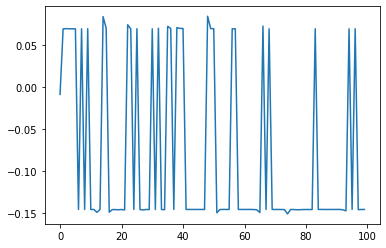

In [152]:
plt.plot(x[0][0:100,0,0].detach().numpy())

In [106]:
!git clone https://github.com/HMEIatJHU/neurawkes

Cloning into 'neurawkes'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 44 (delta 2), reused 0 (delta 0), pack-reused 38
Unpacking objects: 100% (44/44), done.


In [118]:
!python2.7 /content/neurawkes/train_models.py \
    --Model='conttime' --FileData='/content/drive/MyDrive/seq_data/data_bookorder/fold1'


PID is : 2808
TIME is : 2020-11-24T16:15:46.364074
Seed is : 12345
Model is : conttime
CoefL2 is : 0.0
FileData is : /content/drive/MyDrive/seq_data/data_bookorder/fold1
TrainRatio is : 1.0
FilePretrain is : None
TrackPeriod is : 1000
MaxEpoch is : 50
SizeBatch is : 10
Optimizer is : adam
LossType is : loglikehood
WhatTrack is : loss
LearnRate is : 0.001
PartialPredict is : False
PruneStream is : 0
Dev Included Setting is: False
PredictFirst is: True
PredictLambda is: False
reading and processing data ... 
initialize the data processer ... 
reading data for tag :  train
reading data for tag :  dev
finish data processer initialization ... 
building model ... 
get time quantiles ... 
building controller ... 
initializing Neural Hawkes with Continuous-time LSTM ... 
train with log-likelihood ... 
computing loss function of Neural Hawkes model with continuous-time LSTM ... 
creating Adam optimizer ... 
learn rate is set to :  0.001
setting learning rate :  0.001
computing updates ... 
upda

In [127]:
!python2.7 /content/neurawkes/test_models_and_save.py --Model='conttime' --FileData='/content/drive/MyDrive/seq_data/data_bookorder/fold1'


usage: test_models_and_save.py [-h] -m {hawkes,hawkesinhib,conttime} -fd
                               FILEDATA -fp FILEPRETRAIN -ts {dev,test,test1}
                               [-s SEED] [-md MULTIPLEDEV] [-sl {0,1}]
                               [-pp {0,1}] [-ps PRUNESTREAM] [-pf {0,1}]
                               [-pl {0,1}] [-fg FILEGOLD]
                               [-mg {hawkes,hawkesinhib,conttime}]
test_models_and_save.py: error: argument -fp/--FilePretrain is required
